In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sfh as sfh
import torchvision
import gpytorch
import torch
from duste.DustAttnCalc import DustAttnCalc
import duste.DustAttnCalc as dd
import lbg_forecast.dust_priors as dp
import scipy as sc

import lbg_forecast.priors_gp_dust as gpdp

In [2]:
dust_prior = gpdp.DustPrior()
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.n, dust_prior.tau, dust_prior.tau1, dust_prior.ne, dust_prior.taue, dust_prior.tau1e, dust_prior.sfr
recent_sfrs, dust2, dust_index, dust1 = dust_prior.recent_sfrs, dust_prior.dust2, dust_prior.dust_index, dust_prior.dust1

Loading Models
Loading Complete


<ErrorbarContainer object of 3 artists>

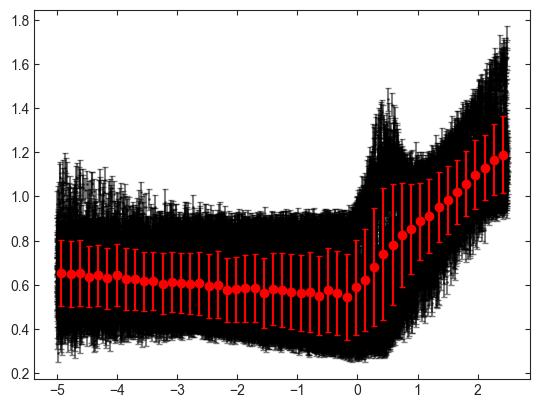

In [3]:
plt.errorbar(sfr, tau, taue, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(sfr, tau, -5, 2.5, 50)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)

<ErrorbarContainer object of 3 artists>

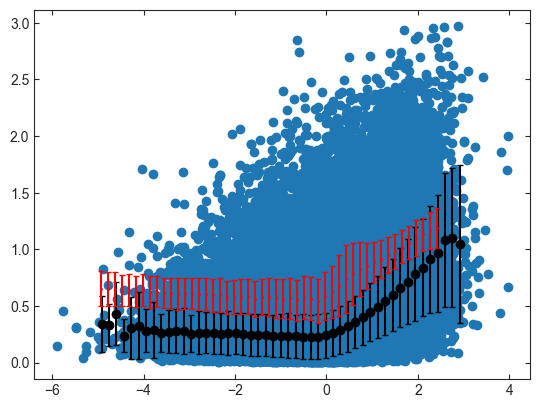

In [4]:
plt.scatter(recent_sfrs, dust2)
bin_centers, bin_means, bin_std = gpdp.process_samples(recent_sfrs, dust2, -5, 3, 50)
plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

In [5]:
train_sfrs, train_dust2, train_dust2_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)
#avg_err = (bin_std + bin_std_de)/2
#x, y, yerr = gpdp.process_samples(train_sfrs, train_dust2, -4, 2.5, 25)
#plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2, alpha=0.25)
#plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2, alpha=0.25)
#plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

In [6]:
#plt.scatter(bin_centers_de, avg_err, c='k')
#a, b, berr = gpdp.process_samples(train_sfrs, train_dust2_errs, -4, 2.5, 40)
#a, b, berr = gpdp.training_data_to_torch(x0, y0, y0err, x, y, yerr)
#plt.errorbar(a, b, berr)
#train_a, train_b, train_berr = torch.from_numpy(a), torch.from_numpy(b), torch.from_numpy(berr)

947.3355491918444
924.9075652091358
901.6595323106336
877.6277239381078
852.8555649751414
827.3936078895063
801.2993726879423
774.6370442617389
747.4770264506766
719.8953581247259
691.9730021458053
663.7950230803006
635.4496739769035
607.0274161454303
578.6198982304056
550.3189216665658
522.2154187876828
494.3984675895599
466.95436385994566
439.9657677358295
413.5109381429444
387.66306499068105
362.48970535710606
338.05232634160245
314.4059540318998
291.59892531066197
269.6727370955173
248.66198607000433
228.59439097556628
209.49088902098083
191.3657978416617
174.2270346362778
158.07638457747376
142.90981131282012
128.71780330605066
115.48575082399974
103.19434936569796
91.82002598899524
81.33538504028463
71.70966907591061
62.90922937509962
54.89799879982151
47.63795850937327
41.089589822308795
35.21230363863437
29.96484207768573
25.305649707972886
21.193214179864267
17.586377669433976
14.444621135724498
11.728323161015329
9.398994438159917
7.419488149817102
5.754185812078029
4.3691577

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


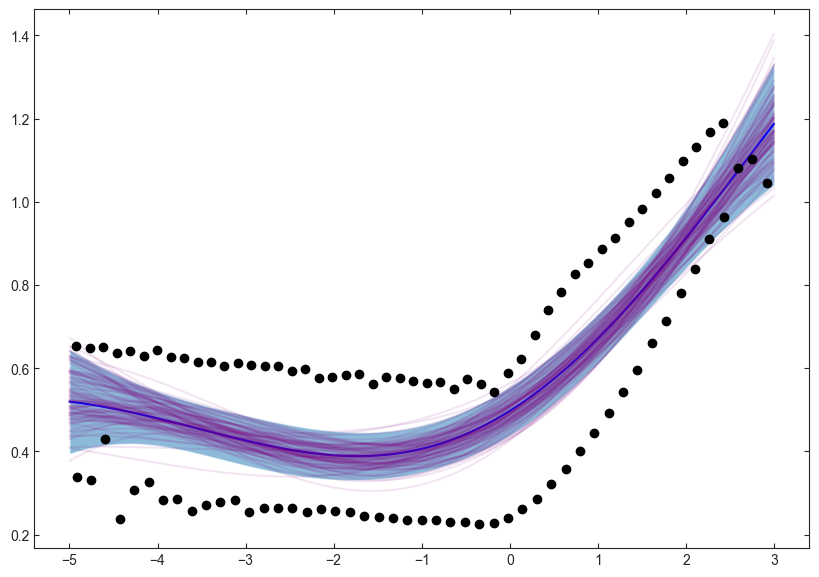

In [7]:
#train_sfrs, train_dust2, train_dust2_errs = torch.from_numpy(x), torch.from_numpy(y), torch.from_numpy(yerr)
test_sfrs = torch.linspace(-5, 3, 100)
trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_sfrs, train_dust2, [5.0, 15.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds_mu = gpdp.gp_evaluate_model(trained_model, test_sfrs)
gpdp.gp_plot_confidence_obs(f_preds_mu, test_sfrs, train_sfrs, train_dust2, train_dust2_errs*0, labelx="", labely="", alpha=0.5)

for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')


with torch.no_grad():
    for i in range(100):
        plt.plot(test_sfrs, f_preds_mu.sample().numpy(), c='purple', alpha=0.1)

In [8]:
#mean = np.interp(test_sfrs, train_sfrs, train_dust2)
#with torch.no_grad():
#    for i in range(500):
#        plt.plot(test_sfrs, f_preds_mu.sample().numpy()+mean, c='purple', alpha=0.1)
#    plt.plot(test_sfrs, mean, c='b')
#    lower, upper = f_preds_mu.confidence_region()
#    plt.fill_between(test_sfrs, lower+mean, upper+mean, alpha=0.2)

In [9]:
#test_sfrs = torch.linspace(-4, 3, 100)
#trained_model_sig, trained_likelihood_sig = gpdp.train_gp_model(torch.from_numpy(bin_centers_de), torch.from_numpy(avg_err), torch.from_numpy(avg_err*0), [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
#f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_sfrs)
#gpdp.gp_plot_confidence_obs(f_preds_sig, test_sfrs, torch.from_numpy(bin_centers_de), torch.from_numpy(avg_err), torch.from_numpy(avg_err*0), labelx="", labely="", alpha=0.5)

#for param_name, param in trained_model_sig.named_parameters():
#    print(f'Parameter name: {param_name:42} value = {param.item()}')

#with torch.no_grad():
#    for i in range(500):
#        plt.plot(test_sfrs, f_preds_sig.sample().numpy(), c='purple', alpha=0.1)

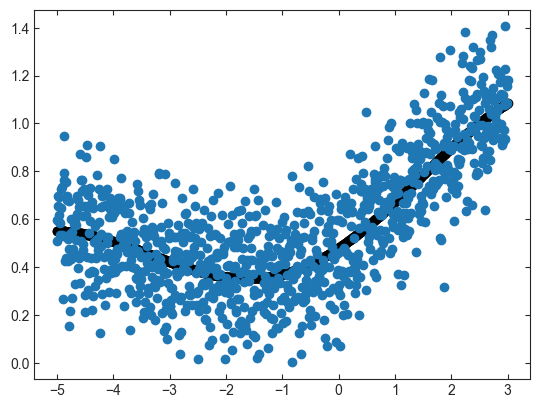

In [10]:
test_sfrs = torch.from_numpy(np.linspace(-5, 3, 1000))
#mean = np.interp(test_sfrs, train_sfrs, train_dust2)
f_preds_mu = gpdp.gp_evaluate_model(trained_model, test_sfrs)
#f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_sfrs)
mean_dust2 = f_preds_mu.sample().numpy()#+mean
#mean_dust2 = np.where(test_sfrs<-1, np.interp(-1, test_sfrs, mean_dust2), mean_dust2)
#sig_dust2 = f_preds_sig.sample().numpy()
#sig_dust2 = np.where(sig_dust2>0.4, 0.4, sig_dust2)
#sig_dust2 = np.where(test_sfrs<-1, 0.2, sig_dust2)
scatter = np.random.uniform(0.1, 0.3)
plt.scatter(test_sfrs, mean_dust2, c='k')
plt.scatter(test_sfrs, dp.truncated_normal(mean_dust2, scatter, 0.0, 4.0, len(test_sfrs)))

In [11]:
torch.save(trained_model.state_dict(), 'gp_models/dust2.pth')

<ErrorbarContainer object of 3 artists>

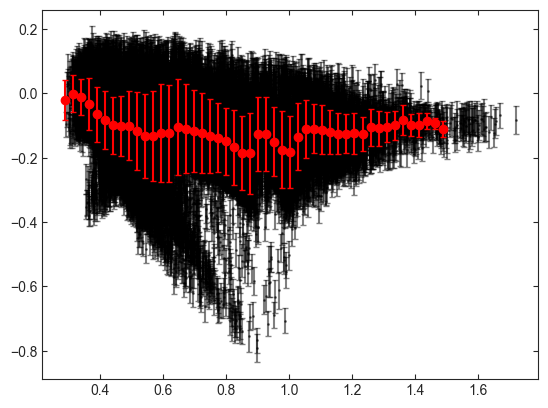

In [12]:
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(tau, n, 0.25, 1.5, 50)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(tau, n, ne, fmt='ko', ms=1, capsize=2, alpha=0.5, zorder=-1)

<ErrorbarContainer object of 3 artists>

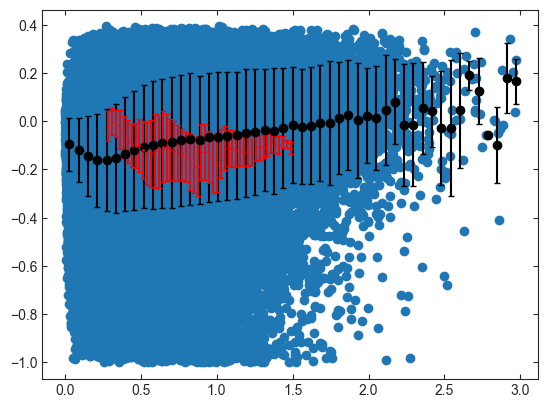

In [13]:
plt.scatter(dust2, dust_index)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust_index, 0.0, 3.0, 50)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)

In [14]:
train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)
#avg_err = (bin_std + bin_std_de)/2
#x, y, yerr = gpdp.process_samples(train_sfrs, train_dust_index, 0.0, 3.0, 50)
#plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2, alpha=0.25)
#plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2, alpha=0.25)
#plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

88.91618448870437
82.10813628342346
75.25958252717106
68.41458820652178
61.621328567002344
54.93164429084432
48.40040160369927
42.084636110765075
36.04246222893158
30.33173509740954
25.008459189626354
20.12494871944907
15.727761355906612
11.855451212920102
8.536222005867653
5.785608142568047
3.60436913163844
1.9768446005183273
0.8700690656574012
0.23396409908084942
0.0028818532919726064
-0.04523346831081548
-0.09344165289084613
-0.14175614881316875
-0.19013624339306137
-0.23853875095239852
-0.28691808014601716
-0.3352262269337395
-0.383412707236925
-0.43142444119552437
-0.47920559973237636
-0.5266974235713058
-0.5738380247855205
-0.6205621812626514
-0.6668011350710624
-0.7124824065097727
-0.7575296365269766
-0.8018624710994203
-0.8453965019796933
-0.8880432788684657
-0.9297104085404372
-0.9703017568377947
-1.0097177699840625
-1.0478559327759263
-1.0846113834229694
-1.1198777086580909
-1.153547948494143
-1.1855158472813254
-1.2156773951644473
-1.2439327091221177
-1.270188301954793
-1.29

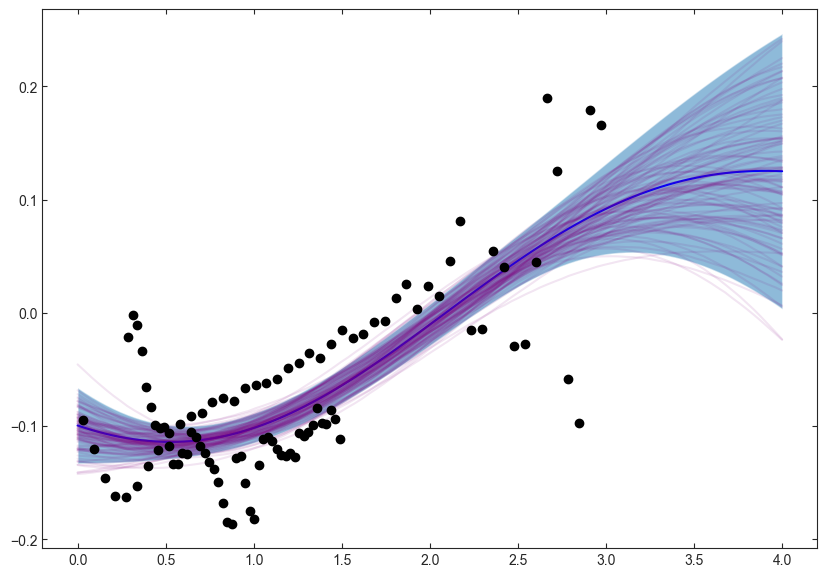

In [15]:
#train_dust2, train_dust_index, train_dust_index_errs = torch.from_numpy(bin_centers), torch.from_numpy(bin_means), torch.from_numpy(bin_std)

test_dust2 = torch.linspace(0, 4, 100)
#train_dust2, train_dust_index, train_dust_index_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, x, y, yerr)

trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_dust2, train_dust_index, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust_index, train_dust_index_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

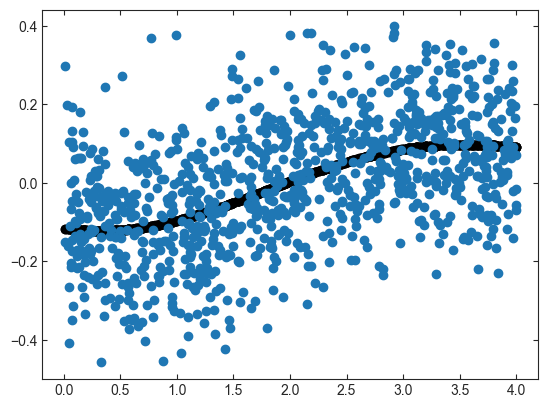

In [16]:
test_tau = torch.from_numpy(np.random.uniform(0, 4, 1000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_tau)
mean_dust_index = f_preds.sample().numpy()
scatter = np.random.uniform(0.1, 0.4)
plt.scatter(test_tau, mean_dust_index, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust_index, scatter, -2.2, 0.4, len(test_tau)))

In [17]:
torch.save(trained_model.state_dict(), 'gp_models/dust_index.pth')

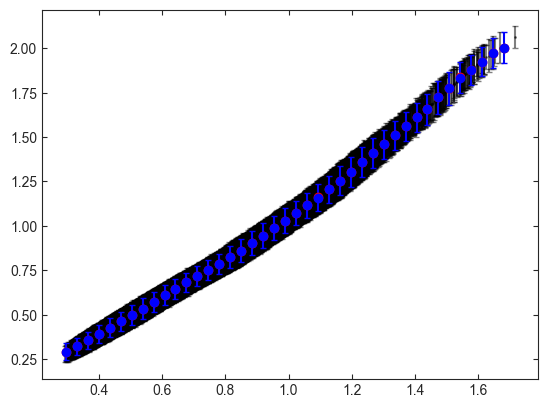

In [18]:
plt.errorbar(tau, tau1, tau1e, fmt='ko', ms=1, capsize=2, alpha=0.5)
bin_centers_de, bin_means_de, bin_std_de = gpdp.process_samples(tau, tau1, 0.0, 1.7, 50)
x, y, yerr = gpdp.process_samples_modified(tau, tau1, tau1e, 0.0, 1.7, 50)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', capsize=2)
plt.errorbar(x, y, yerr, fmt='bo', capsize=2)

bin_centers_de, bin_means_de, bin_std_de = x, y, yerr


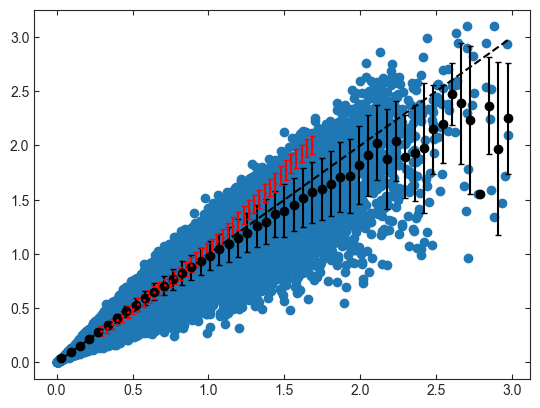

In [19]:
plt.scatter(dust2, dust1)

bin_centers, bin_means, bin_std = gpdp.process_samples(dust2, dust1, 0.0, 3.0, 50)

plt.errorbar(bin_centers, bin_means, bin_std, fmt='ko', capsize=2)
plt.errorbar(bin_centers_de, bin_means_de, bin_std_de, fmt='ro', ms=1, capsize=2)
plt.plot(bin_centers, bin_centers, c='k', ls='--')

95.80838859324311
88.4757435494051
81.09981423819744
73.72809844878564
66.41244221277249
59.208598919740275
52.17565418160462
45.37509433234386
38.86958708857601
32.72152337552847
26.991298675584474
21.735329812245915
17.003827980341466
12.838377149304259
9.269405014705882
6.3136842565059
3.9720639674753024
2.2276978496845334
1.045091661564874
0.37031230609644067
0.13265378262736713
0.09303466991198615
0.05410371633797081
0.01592951770028907
-0.0213519652845859
-0.05759675828170633
-0.09265373301916985
-0.12636562257696982
-0.15857034249835616
-0.18910277180194585
-0.2177971514182859
-0.2444902570419583
-0.26902549361282524
-0.29125803229571484
-0.3110610584334727
-0.32833310936350524
-0.34300634303303684
-0.3550553841805059
-0.36450614563620315
-0.37144373612736775
-0.3760182865654524
-0.3784473290390323
-0.37901334855337543
-0.3780554044235113
-0.37595435700250757
-0.3731122156644864
-0.3699272915578224
-0.3667679107660033
-0.3639480838864498
-0.3617084772337782
-0.3602052312214444
-

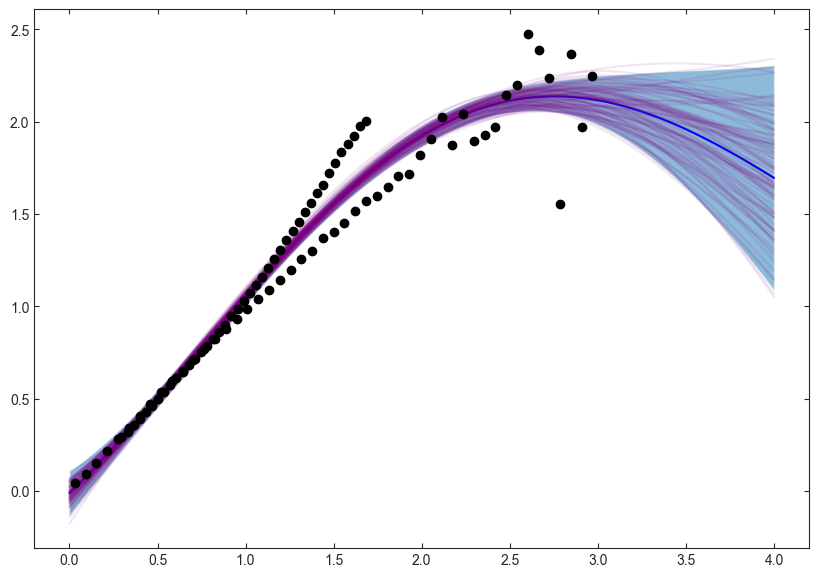

In [20]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust1, train_dust1_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

trained_model, trained_likelihood = gpdp.train_gp_model_noerr(train_dust2, train_dust1, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1, train_dust1_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

95.77802382054611
88.44364287915111
81.06570589986481
73.69171000837441
66.37358230878557
59.16720105093559
52.131706488231096
45.3285784584021
38.8204611046283
32.66972062171699
26.936729865468557
21.677885393184916
16.94338018465369
12.774781614090546
9.202501857594854
6.243298432096967
3.8980046649520705
2.1497566343151724
0.9630390217668238
0.2838922716973296
0.041576370445212674
-0.003155342722130018
-0.047618997281179035
-0.09180634226143349
-0.1356495850739053
-0.17907835026927724
-0.22201991456337236
-0.26439918641445137
-0.30613838771995067
-0.3471564233977599
-0.38736797640099346
-0.4266824302636123
-0.46500277825065084
-0.5022247061915462
-0.5382360252647503
-0.5729165909271167
-0.6061387993623745
-0.6377687276979545
-0.6676679878261726
-0.6956963843005418
-0.7217154793574946
-0.7455931479522856
-0.7672091402903465
-0.7864615621846087
-0.8032740496683171
-0.817603271529152
-0.829446255847289
-0.8388469135952563
-0.8459010337358215
-0.8507589677054481
-0.8536252364294766
-0.8

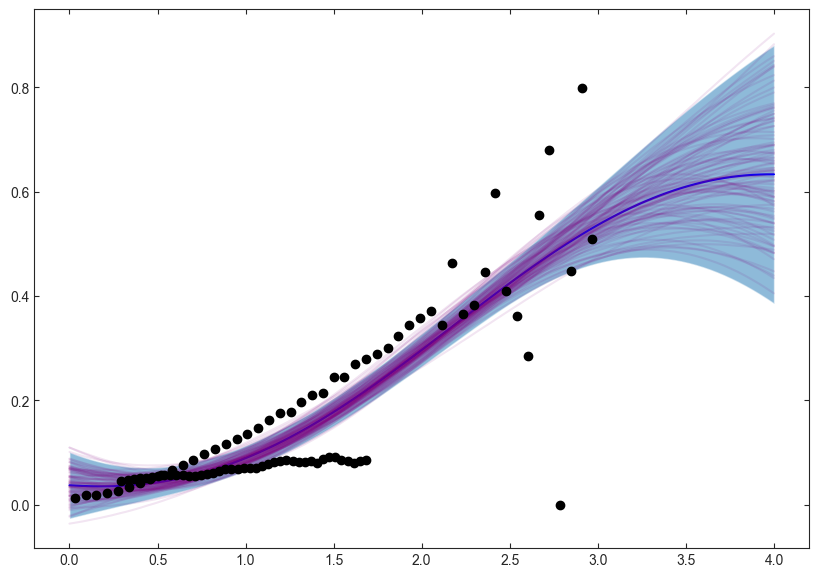

In [21]:
test_dust2 = torch.linspace(0, 4, 100)
train_dust2, train_dust1, train_dust1_errs = gpdp.training_data_to_torch(bin_centers, bin_means, bin_std, bin_centers_de, bin_means_de, bin_std_de)

trained_model_sig, trained_likelihood_sig = gpdp.train_gp_model_noerr(train_dust2, train_dust1_errs, [2.0, 10.0], [-100, 100], lr=0.1, training_iter=10000)
f_preds = gpdp.gp_evaluate_model(trained_model_sig, test_dust2)
gpdp.gp_plot_confidence_obs(f_preds, test_dust2, train_dust2, train_dust1_errs, train_dust1_errs*0, labelx="", labely="", alpha=0.5)
for param_name, param in trained_model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

with torch.no_grad():
    for i in range(100):
        plt.plot(test_dust2, f_preds.sample().numpy(), c='purple', alpha=0.1)

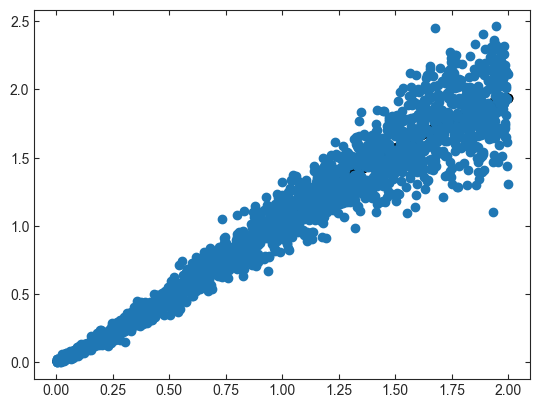

In [22]:
test_tau = torch.from_numpy(np.random.uniform(0, 2, 2000))
f_preds = gpdp.gp_evaluate_model(trained_model, test_tau)
f_preds_sig = gpdp.gp_evaluate_model(trained_model_sig, test_tau)
mean_dust1 = f_preds.sample().numpy()
sig_dust1 = f_preds_sig.sample().numpy()
sig_dust1 = np.where(sig_dust1<0.001, 0.001, sig_dust1)
#scatter = np.random.uniform(0.05, 0.4)
plt.scatter(test_tau, mean_dust1, c='k')
plt.scatter(test_tau, dp.truncated_normal(mean_dust1, sig_dust1, 0.0, 4.0, len(test_tau)))

In [23]:
torch.save(trained_model.state_dict(), 'gp_models/dust1.pth')
torch.save(trained_model_sig.state_dict(), 'gp_models/dust1sig.pth')